# Love and Relationships in British Novels of the Nineteenth Century

In [ ]:
import pandas as pd
import requests
import string
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from adjustText import adjust_text

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
#from nltk.sentiment.vader import SentimentIntensityAnalyzer

ana = SentimentIntensityAnalyzer()

from SPARQLWrapper import SPARQLWrapper, JSON
import ssl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from os.path import join
import re
from tqdm import tqdm
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd


try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [ ]:
def remove_pg_boilerplate(complete_file):
    
    lines = re.split( r'\n' , complete_file )
    read_mode = 0 
    full_text = ''
    
    for line in lines:
        #print(line)
        if read_mode == 1:
            full_text += line + '\n'
            
        if re.search( r'\*{3,}\s+START\s+OF\s+TH(E|IS)\s+PROJECT\s+GUTENBERG\s+EBOOK' ,  str(line) , re.IGNORECASE ):
            read_mode = 1
        if re.search( r'\*{3,}\s+END\s+OF\s+TH(E|IS)\s+PROJECT\s+GUTENBERG\s+EBOOK' ,  str(line) , re.IGNORECASE ):
            read_mode = 0
            
    full_text = full_text.strip()
    if re.search( r'^Produced by' , full_text , re.IGNORECASE ):
        full_text = full_text[ full_text.index('\n') : len(full_text) ]
    return full_text

def format_filename(text):
    file_name = re.sub(r'[{}]'.format(string.punctuation),'',text)
    file_name = re.sub(r'\s+','_',file_name).lower().strip()
    return file_name.lower()

def extract_title(file_name):
    title = os.path.basename(file_name)
    title = re.sub( r'[.]txt$' , '' , title )
    return title

def sorted_by_value( dict , ascending = True ):
    if ascending: 
        return {k: v for k, v in sorted(dict.items(), key=lambda item: item[1])}
    else:
        return {k: v for k, v in reversed( sorted(dict.items(), key=lambda item: item[1]))}
    

The list below firsty identifies a number of notable British authors from the Nineteenth Century. The form of the names in this list correspond to the form given on Project Gutenberg.  

In [ ]:
author_names = [
'Austen Jane',
'Brontë Emily',
'Brontë Charlotte',
'Burney Fanny',
'Shelley Mary Wollstonecraft',
'Thackeray William Makepeace',
'Stevenson Robert Louis',
'Scott Walter',
'Collins Wilkie',
'James Henry',
'Butler Samuel',
'Ouida',
'Trollope Anthony',
'Ainsworth William Harrison',
'Eliot George',
'Carroll Lewis',
'Sewell Anna',
'Hardy Thomas',
'Dickens Charles'    
]

The metadata from Project Gutenberg can be downloaded. Using the list of authors mentioned above, we can create a CSV file of all the works by these authors that are available on Project Gutenberg. The CSV file includes the titles, the URL of the full text and the year of publication. 

In [ ]:
pg = pd.read_csv('pg_titles.tsv',sep='\t')

In [ ]:
text_year = dict()

for i,row in pg.iterrows():
    file_name = format_filename(row['title'])
    file_name = f'{file_name}.txt'
    text_year[file_name] = row['year']

The cell below downloads all the texts. Depending on the year of publication, the texts are assigned either to the 'early' corpus (books published before 1845) or the 'late' corpus (books published after 1855). 

In [ ]:
directory = 'PG_texts'
if not os.path.exists(directory):
    os.makedirs(directory)

for i,row in pg.iterrows():
    sub_dir = ''
    if int(row['year']) > 1855:
        sub_dir = 'late'
    elif int(row['year']) < 1845:
        sub_dir = 'early'
    
    if sub_dir == 'late':
        title = row['title']
        file_name = format_filename(title)
        file_name = f'{file_name[:100]}.txt'

        url = row['url']

        path = join(directory,sub_dir,file_name)
        response = requests.get(url)
        response.encoding = 'utf-8'
        out = open( path , mode='w',encoding= 'utf-8' )
        out.write( remove_pg_boilerplate(response.text) )
        out.close()

The aim is to compare texts written at the beginning of the century to texts written in the second half of the centrury. The number of words is not identical. The "late" corpus contains a much higher number of weords. The cell below removes a number of files from the "late" corpus, to ensure that the tqo subcorpora contain roughy the same number of words. The word count has been set to 3 million words. 

In [ ]:
subdir = 'early'
files_early = os.listdir(join(directory,subdir))
files_early = [join(directory,subdir,file) for file in files_early if not(re.search(r'^[.]',file))]

subdir = 'late'
files_late = os.listdir(join(directory,subdir))
files_late = [join(directory,subdir,file) for file in files_late if not(re.search(r'^[.]',file))]

In [ ]:
nr_words_early = 0
nr_words_late = 0
max_nr_words = 3000000

for file in files_early:
    fh = open(file,encoding='utf-8')
    full_text = fh.read()
    words = word_tokenize(full_text)
    words = [word for word in words if word not in string.punctuation]
    nr_words_early += len(words)
    if nr_words_early > max_nr_words:
        files_to_remove.append(file)
    
print(f'"Early" corpus contains {nr_words_early} words')
    
files_to_remove = []    
for file in files_late:
    fh = open(file,encoding='utf-8')
    full_text = fh.read()
    words = word_tokenize(full_text)
    words = [word for word in words if word not in string.punctuation]
    nr_words_late += len(words)
    if nr_words_late > max_nr_words:
        files_to_remove.append(file)
        
print(f'"Late" corpus contains {nr_words_late} words')

In [ ]:
for file in files_to_remove:
    os.remove(file) 

The dataset that is results is divided into two subgroups: (1) books published before 1845 and (2) books published after 1855. 

## Searching with a lexicon

We make use of a lexicon containing words that have to do with love and relationships. Next, we count how often the word in this lexison are used in each of the the books. 

In [189]:
lexicon = []
lexicon_file = open('love_lexicon',encoding='utf-8')
for term in lexicon_file:
    lexicon.append(term.strip())
    
lexicon = [term.lower() for term in lexicon]

In [190]:
data = []
terms = dict()

In [191]:
# total number of occurrences
total_count = 0
# Total number per text
text_count = dict()
# Counts for specific lexicon terms
term_count = dict()

directory = 'PG_texts'
sub_dir = 'early'

files = os.listdir(join(directory,sub_dir))
files = [join(directory,sub_dir,file) for file in files if not(re.search(r'^[.]',file))]

files_early = files

for file in tqdm(files):
    count = 0
    full_text = ''
    with open(file,encoding='utf-8') as fh:
        full_text = fh.read()
    words = word_tokenize(full_text.lower())
    word_freq = Counter(words)

    for word in word_freq.keys():
        
        if word in lexicon:
            count+=1
            term_count[word] = term_count.get(word,0)+1
    
    total_count += count
    text_count[file] = count
    
row = []
row.append(sub_dir)
row.append(total_count)
data.append(row)
        
terms['early'] = term_count

100%|███████████████████████████████████████████| 21/21 [00:26<00:00,  1.28s/it]


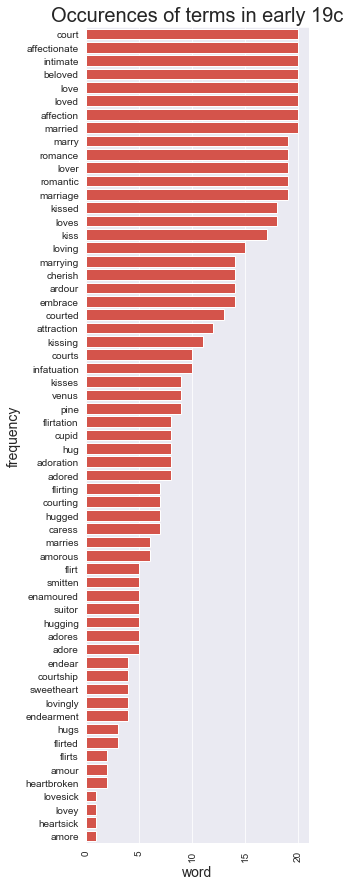

In [192]:
term_count = sorted_by_value(term_count,ascending=False)

x_axis = list(term_count.values())
y_axis = list(term_count.keys())

fig = plt.figure( figsize=( 4 , 15) )
sns.set_style("darkgrid")

graph = sns.barplot( x=x_axis, y=y_axis, dodge = False , color = '#eb4034' )

graph.set_title(f'Occurences of terms in {sub_dir} 19c' , size = 20) 
graph.set_xlabel('word' , size = 14) 
graph.set_ylabel('frequency' , size = 14 )

plt.xticks(rotation= 90)

plt.show()

In [193]:
# total number of occurrences
total_count = 0
# Total number per text
text_count = dict()
# Counts for specific lexicon terms
term_count = dict()

directory = 'PG_texts'
sub_dir = 'late'

files = os.listdir(join(directory,sub_dir))
files = [join(directory,sub_dir,file) for file in files if not(re.search(r'^[.]',file))]

files_late= files

for file in tqdm(files):
    count = 0
    full_text = ''
    with open(file,encoding='utf-8') as fh:
        full_text = fh.read()
    words = word_tokenize(full_text.lower())
    word_freq = Counter(words)

    for word in word_freq.keys():
        
        if word in lexicon:
            count+=1
            term_count[word] = term_count.get(word,0)+1
    
    total_count += count
    text_count[file] = count
    
row = []
row.append(sub_dir)
row.append(total_count)
data.append(row)
        
terms['late'] = term_count

100%|███████████████████████████████████████████| 22/22 [00:23<00:00,  1.06s/it]


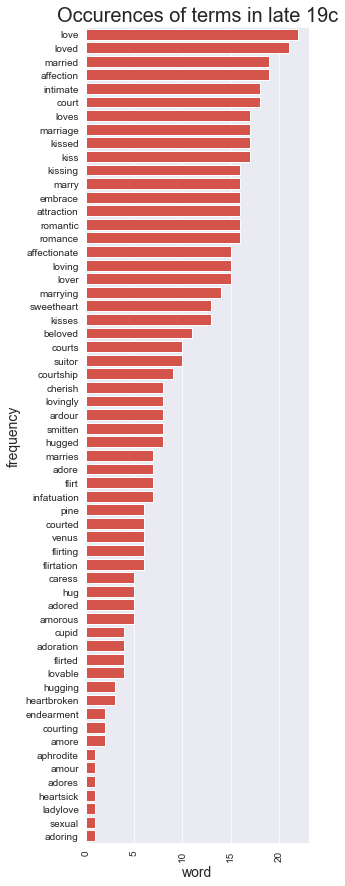

In [194]:
term_count = sorted_by_value(term_count,ascending=False)

x_axis = list(term_count.values())
y_axis = list(term_count.keys())

sns.set_style("darkgrid")

fig = plt.figure( figsize=( 4 , 15) )

graph = sns.barplot( x=x_axis, y=y_axis, dodge = False , color = '#eb4034' )

graph.set_title(f'Occurences of terms in {sub_dir} 19c' , size = 20) 
graph.set_xlabel('word' , size = 14) 
graph.set_ylabel('frequency' , size = 14 )

plt.xticks(rotation= 90)

plt.show()

Is the number of 'love' words in the "late" corpus higher that the count of these words in the "early" corpus?

In [195]:
x_axis = []
y_axis = []
for row in data:
    x_axis.append(row[0])
    y_axis.append(row[1])

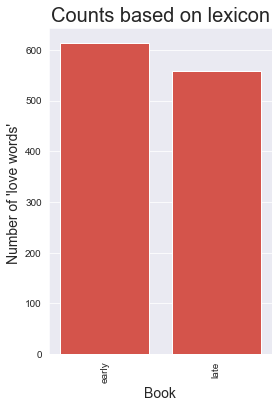

In [196]:
fig = plt.figure( figsize=(4,6) )

graph = sns.barplot( x=x_axis, y=y_axis, dodge = False , color = '#eb4034' )

graph.set_title('Counts based on lexicon' , size = 20) 
graph.set_xlabel('Book' , size = 14) 
graph.set_ylabel('Number of \'love words\' ' , size = 14 )

plt.xticks(rotation= 90)

plt.show()

In [197]:
early_dict = terms['early']
late_dict = terms['late']

x_axis = []
y_axis = []
labels = []

for term in lexicon:
    x_axis.append(early_dict.get(term,0))
    y_axis.append(late_dict.get(term,0))
    labels.append(term)

The scatter plot below compares the frequencies in the early and in the late corpus. Words that are shown above the diagonal line are more frequesnt in the "late" corpus.

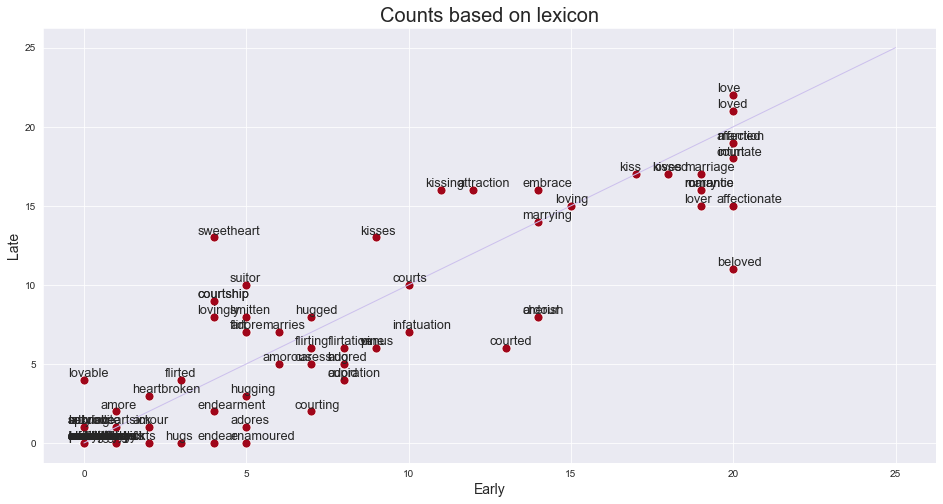

In [200]:

fig = plt.figure( figsize = ( 16,8))

ax = sns.scatterplot( x = x_axis , y = y_axis , color = '#a0061a' , s = 80 ) 


    
ax.set_title('Counts based on lexicon' , size = 20) 
ax.set_xlabel('Early' , size = 14) 
ax.set_ylabel('Late' , size = 14 )

for i,label in enumerate(labels):
    plt.text( x_axis[i]-0.5,y_axis[i]+0.2,label, 
             fontsize=12.8 )
    
# Draw a line of x=y 
plt.plot([25,0], [25, 0], linewidth=1, color = '#ccc0ed')

plt.show()

## Sentiment Analysis

In [201]:
sentiment_scores = dict()

for file in files_early:

    fh = open(file,encoding='utf-8')
    full_text = fh.read()
    sentences = sent_tokenize(full_text) 
    for sentence in sentences:
        sentence = re.sub(r'\s+', ' ',sentence)
        words = word_tokenize(sentence)
        match = False
        for word in words:
            if word in lexicon:
                match = True
            if match:    
                scores = ana.polarity_scores(sentence)
                sentiment_scores[sentence] = scores['compound']

What are the most negative sentences in the "early" corpus?

In [202]:
iterator = iter(sorted_by_value(sentiment_scores).items())
for i in range(10):
    item = next(iterator)
    print(item[0], item[1])

But to be murdered thus at the midnight hour by cold-blooded assassins, no friendly hand to close my eyes, or receive my parting blessing—to die in combat, hate and execration—ah, why, my angel love, didst thou restore me to life, when already I had stepped within the portals of the tomb, now that so soon again I was to be flung back a mangled corpse! -0.9782
But worse than absence, worse than death, She wept her lover's sullied fame, And, fired with all the pride of birth, She wept a soldier's injured name. -0.978
But Elinor had no such dependence; for since Edward would still be unable to marry Miss Morton, and his chusing herself had been spoken of in Mrs. Ferrars’s flattering language as only a lesser evil than his chusing Lucy Steele, she feared that Robert’s offence would serve no other purpose than to enrich Fanny. -0.9568
I would have forfeited for him double the value of these lands, which he pursues with an ardour that shows he has forgotten how much I am implicated in the ma

What are the most positive sentences in the "early" corpus?

In [203]:
iterator = iter(sorted_by_value(sentiment_scores,ascending=False).items())
for i in range(10):
    item = next(iterator)
    print(item[0], item[1])

I am sure you will be glad to hear, as likewise dear Mrs. Jennings, I spent two happy hours with him yesterday afternoon, he would not hear of our parting, though earnestly did I, as I thought my duty required, urge him to it for prudence sake, and would have parted for ever on the spot, would he consent to it; but he said it should never be, he did not regard his mother’s anger, while he could have my affections; our prospects are not very bright, to be sure, but we must wait, and hope for the best; he will be ordained shortly; and should it ever be in your power to recommend him to any body that has a living to bestow, am very sure you will not forget us, and dear Mrs. Jennings too, trust she will speak a good word for us to Sir John, or Mr. Palmer, or any friend that may be able to assist us.—Poor Anne was much to blame for what she did, but she did it for the best, so I say nothing; hope Mrs. Jennings won’t think it too much trouble to give us a call, should she come this way any m

What are the most negative words used in the context of the words referring to "love and relationships" in the "early" corpus?

In [204]:
words_freq = Counter()
for sentence in sentiment_scores:
    words = word_tokenize(sentence.lower())
    words = [word for word in words if word not in lexicon]
    words_freq.update(words)
    
for word,count in words_freq.most_common():
    score = ana.polarity_scores(word)['compound']
    if score< -0.6:
        if count>5:
            print(f'{word} ({count})')

dead (43)
evil (29)
violence (15)
worst (11)
hatred (10)
hated (9)
betrayed (9)
dismal (6)
kill (6)


What are the most positive words used in the context of the words referring to "love and relationships" in the "early" corpus?

In [205]:
for word,count in words_freq.most_common():
    score = ana.polarity_scores(word)['compound']
    if score>0.6:
        if count>5:
            print(f'{word} ({count})')

heart (276)
great (230)
best (91)
perfectly (39)
hearts (26)
greatest (23)
freedom (10)
happiest (8)
excellence (6)
paradise (6)
love. (6)
glee (6)


In [206]:
data = []
count_positive=0
count_negative=0
count_neutral=0

nr_sentences = len(sentiment_scores)

for sentence in sentiment_scores:
    if sentiment_scores[sentence]<-0.6:
        count_negative+=1
    elif sentiment_scores[sentence]>0.6:
        count_positive+=1
    else:
        count_neutral+=1
          
data.append( ['Early',count_neutral/nr_sentences,count_positive/nr_sentences,count_negative/nr_sentences] )

In [207]:
sentiment_scores = dict()

for file in files_late:
    fh = open(file,encoding='utf-8')
    full_text = fh.read()
    sentences = sent_tokenize(full_text) 
    for sentence in sentences:
        sentence = re.sub(r'\s+', ' ',sentence)
        words = word_tokenize(sentence)
        match = False
        for word in words:
            if word in lexicon:
                match = True
            if match:    
                scores = ana.polarity_scores(sentence)
                sentiment_scores[sentence] = scores['compound']


What are the most negative sentences in the early corpus?

In [208]:
iterator = iter(sorted_by_value(sentiment_scores).items())
for i in range(10):
    item = next(iterator)
    print(item[0], item[1])

‘As if fate impelled her to her death, one day the Princess, as her guards turned out, and she was aware that the Prince was standing, as was his wont, on the landing, conversing with his gentlemen (in the old days he used to cross to the Princess’s apartment and kiss her hand)--the Princess, who had been anxious all the morning, complaining of heat, insisting that all the doors of the apartments should be left open; and giving tokens of an insanity which I think was now evident, rushed wildly at the doors when the guards passed out, flung them open, and before a word could be said, or her ladies could follow her, was in presence of Duke Victor, who was talking as usual on the landing: placing herself between him and the stair, she began apostrophising him with frantic vehemence:-- ‘“Take notice, gentlemen!” she screamed out, “that this man is a murderer and a liar; that he lays plots for honourable gentlemen, and kills them in prison! -0.9738
But after twenty-one years the defendant’s

What are the most positive sentences in the "late" corpus?

In [209]:
iterator = iter(sorted_by_value(sentiment_scores,ascending=False).items())
for i in range(10):
    item = next(iterator)
    print(item[0], item[1])

mon maitre!” I loved the movement with which she confided her hand to my hand; I loved her as she stood there, penniless and parentless; for a sensualist charmless, for me a treasure--my best object of sympathy on earth, thinking such thoughts as I thought, feeling such feelings as I felt; my ideal of the shrine in which to seal my stores of love; personification of discretion and forethought, of diligence and perseverance, of self-denial and self-control--those guardians, those trusty keepers of the gift I longed to confer on her--the gift of all my affections; model of truth and honour, of independence and conscientiousness--those refiners and sustainers of an honest life; silent possessor of a well of tenderness, of a flame, as genial as still, as pure as quenchless, of natural feeling, natural passion--those sources of refreshment and comfort to the sanctuary of home. 0.996
I hate boldness--that boldness which is of the brassy brow and insensate nerves; but I love the courage of th

What are the most negative words used in the context of the words referring to "love and relationships" in the "late" corpus?

In [210]:
words_freq = Counter()
for sentence in sentiment_scores:
    words = word_tokenize(sentence.lower())
    words = [word for word in words if word not in lexicon]
    words_freq.update(words)
    
for word,count in words_freq.most_common():
    score = ana.polarity_scores(word)['compound']
    if score< -0.6:
        if count>5:
            print(f'{word} ({count})')

dead (27)
hated (18)
evil (11)
worst (7)
kill (7)
murdered (7)
betrayed (6)
hatred (6)
devil (6)
murder (6)


What are the most positive words used in the context of the words referring to "love and relationships" in the "late" corpus?

In [211]:
for word,count in words_freq.most_common():
    score = ana.polarity_scores(word)['compound']
    if score>0.6:
        if count>5:
            print(f'{word} ({count})')

heart (203)
great (151)
best (76)
hearts (17)
greatest (11)
perfectly (6)
freedom (6)


In [212]:

count_positive=0
count_negative=0
count_neutral=0

nr_sentences = len(sentiment_scores)

for sentence in sentiment_scores:
    if sentiment_scores[sentence]<-0.6:
        count_negative+=1
    elif sentiment_scores[sentence]>0.6:
        count_positive+=1
    else:
        count_neutral+=1
        

data.append( ['Late',count_neutral/nr_sentences,count_positive/nr_sentences,count_negative/nr_sentences] )

In [213]:
df = pd.DataFrame(data,columns=['period','neutral','positive','negative'])

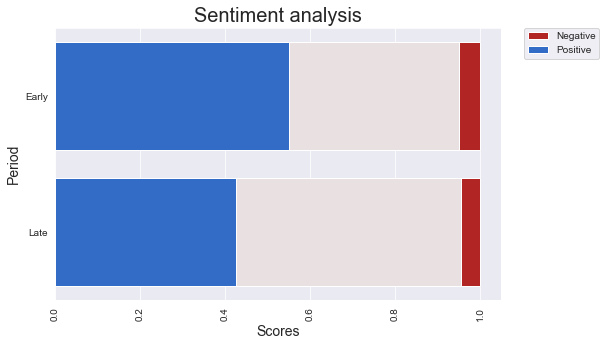

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


y_axis = 'period'

fig = plt.figure( figsize=( 8 , 5 ) )

df['combined'] = df['positive'] + df['neutral'] + df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Negative', color = '#c90e0e' )
df['combined'] = df['combined'] - df['negative']
graph = sns.barplot( data=df , x='combined', y=y_axis , color = '#ebdfdf')
df['combined'] = df['combined'] - df['neutral']
graph = sns.barplot( data=df , x='combined', y=y_axis , label = 'Positive' ,color = '#1b66de')

graph.set_title('Sentiment analysis' , size = 20) 
graph.set_xlabel('Scores' , size = 14) 
graph.set_ylabel('Period' , size = 14 )

plt.xticks(rotation= 90)

# The next line places the legend outside out the plot
plt.legend( bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.);

plt.show()

## Collocation analysis

Which words are used in the vicinity of the words on the 'love lexicon'?

In [216]:
from nltk.corpus import stopwords
import string
stopword_list = stopwords.words('english')
stopword_list.extend(['”','“','’'])
for punct in string.punctuation:
    stopword_list.append(punct)

for file in files:
    collocations = Counter()
    other_words = []
    
    title = os.path.basename(file)
    title = re.sub( r'[.]txt$' , '' , title )
    print(f"\n{title}\n")

    full_text = ''
    with open(file,encoding='utf-8') as file:
        full_text = file.read()
    full_text = re.sub(r'\s+',' ',full_text)
    sentences = sent_tokenize(full_text)
    for sent in sentences:
        words = word_tokenize(sent)
        match = False
        for word in words:
            if word in lexicon:
                match = True
            if match:
                for word in words:
                    if word not in lexicon and word not in stopword_list and len(word)>2:
                        other_words.append(word)
    
    collocations = Counter(other_words)
    for word,count in collocations.most_common(10):
        print(f'{word} {count}')


The_Turn_of_the_Screw

little 199
The 94
never 72
constant 66
Then 57
know 56
take 56
face 54
child 50
upon 49

The_American_Senator

would 2500
man 1404
She 821
girl 781
could 769
young 746
Mary 744
Morton 704
one 660
might 654

The_Death_of_the_Lion

n't 52
feather 49
cap 49
gives 49
importance 49
could 49
naturally 49
pretend 49
seek 49
deprive 49

Poor_Miss_Finch

first 594
would 593
Lucilla 561
brother 502
Oscar 502
man 475
The 444
one 432
time 337
place 290

Tales_of_All_Countries_Second_Series

would 3039
man 1106
She 1066
But 1056
much 1020
said 987
could 952
And 893
might 839
though 766

The_Moonstone

Mr. 868
said 533
Rachel 444
Franklin 437
first 428
Miss 415
lady 400
engagement 313
The 311
heart 303

A_Footnote_to_History_Eight_Years_of_Trouble_in_Samoa

German 208
The 183
would 173
law 127
come 122
chief 119
great 116
hand 115
martial 112
Samoa 111

Confidence

Gordon 604
Bernard 416
Wright 254
Vivian 251
would 240
friend 209
n't 197
one 196
Blanche 186
daughter 178

The_

In [217]:
for file in files:
    
    title = os.path.basename(file)
    title = re.sub( r'[.]txt$' , '' , title )
    print(f"\n{title}\n")

    full_text = ''
    with open(file,encoding='utf-8') as file:
        full_text = file.read()
    full_text = re.sub(r'\s+',' ',full_text)
    sentences = sent_tokenize(full_text)
    for sent in sentences:
        words = word_tokenize(sent)
        match = False
        for word in words:
            if word in lexicon:
                match = True
        if match:
            print(sent)


The_Turn_of_the_Screw

Yes, she was in love.
“Who was it she was in love with?” “The story will tell,” I took upon myself to reply.
“Well, if I don’t know who she was in love with, I know who _he_ was.” “She was ten years older,” said her husband.
But as my little conductress, with her hair of gold and her frock of blue, danced before me round corners and pattered down passages, I had the view of a castle of romance inhabited by a rosy sprite, such a place as would somehow, for diversion of the young idea, take all color out of storybooks and fairytales.
She expressed in her little way an extraordinary detachment from disagreeable duties, looking to me, however, with a great childish light that seemed to offer it as a mere result of the affection she had conceived for my person, which had rendered necessary that she should follow me.
I needed nothing more than this to feel the full force of Mrs. Grose’s comparison, and, catching my pupil in my arms, covered her with kisses in which th

She rather liked being hated by women and did not want any man to be in love with her,--except as far as might be sufficient for the purpose of marriage.
There had been a young man, of immense wealth, of great rank, whom at one time she really had fancied that she had loved;--but just as she was landing her prey, the prey had been rescued from her by powerful friends, and she had been all but broken-hearted.
Morton had intended that the two elder ladies should go together with one of the maids, and that he should put his love into the other, which having a seat behind, could accommodate the second girl without disturbing them in the carriage.
There had not been the smallest spark of love's flame shown as yet, nor did the girl as she sat sipping her tea seem to think that any such spark was wanted.
"What's the use if he's to live always at foreign courts?"
Lady Augustus was not going to let her daughter marry a man who could not give her a home for at any rate a part of the year.
"Of co

Poor Larry whether in his triumph or his sorrow had no gift of reticence and now told his neighbour the whole story of his love.
What makes me mad is that I should love her all the better because she won't.
"I couldn't speak out free to her,--not if it was to save the whole place," said the unfortunate lover.
There was real love,--and though that love was not at present happy it was of a nature to inspire perfect respect.
And she would meet him with the remembrance fresh in his mind as in her own of those passages of love at Rufford.
But her aunt was a woman who had never suffered hardships, whose own marriage had been easily arranged, and whose two daughters had been pleasantly married before they were twenty years old.
She was kissed by her uncle and welcomed with characteristic coldness by her aunt, then allowed to settle in among the other guests as though she had been there all the winter.
He always spent six months in the country, in which he acted as landlord to a great crowd of

Let her stay here and be made to marry Lawrence Twentyman.
"She will never marry Mr.
But I can't compel my girl to marry him if she don't like him.
"And nothing would take such a load off me as to know that she was going to be well married.
She sees nobody here at Dillsborough to be intimate with.
He felt certain that the lover was not there.
But there was a young man in Dillsborough,--one man at any rate young enough to be a lover,--of whom Reginald did not think; as to whom, had his name been suggested as that of the young man to whom Mary's heart had been given, he would have repudiated such a suggestion with astonishment and anger.
But now, having heard this from the girl's father, he was again vexed, and almost as much disgusted as when he had first become aware that Larry Twentyman was a suitor for her hand.
Why should he trouble himself about a girl who was ready to fall in love with the first man that she saw about the place?
I can only say that you have altogether mistaken me 

He had therefore declared it to be his purpose to marry Arabella Trefoil, and because he had so declared he had almost brought himself to forgive that young lady's sins against him.
Or if this were impracticable, there was a distant Morton, very distant, whom she had never seen and certainly did not love, but who was clearly a Morton, and who would certainly be preferable to that enemy of forty years' standing.
Little as she had been at Bragton she knew all about Chowton Farm,--except that its owner was so wounded by vain love as to be like a hurt deer.
Then he would marry and have children, and Bragton would descend in the right line.
The imprudent, weak-minded, loving old woman longed to hear a tale of mutual love,--longed to do something which should cause such a tale to be true on both sides.
She had twice walked back to Dillsborough with Reginald Morton, and he had been more sedate, more middle-aged, less like a lover than ever.
She knew now that she might safely walk with him, be

"Will you have the hardihood to say that you did not love me?"
How is it possible that a man should tell a girl that he has not loved her, when he has embraced her again and again?
He may know it, and she may know it,--and each may know that the other knows it;--but to say that he does not and did not then love her is beyond the scope of his audacity,--unless he be a heartless Nero.
What were you thinking of when we were coming back in the carriage from Stamford,--when with your arms round me you swore that you loved me better than all the world?
There was a moment in which he thought it was almost a pity that he had not married her.
He had not wanted money and why shouldn't he have married her?
With her it was a matter of bargain, not of love.
Were you lying when you told me that you loved me?"
"Did I lie when I told the Duchess that you had promised me your love?
Did I lie when I told my mother that in these days a man does not always mention marriage when he asks a girl to be his wi

Hate is difficult and expensive, and between individuals soon gives place to love.
It should not be his fault if the absurdities of a people whom he really loved were not exposed to light, so that they might be acknowledged and abandoned.
Would any man be so unjust to those who are equal in his love, were he not constrained by law, and by custom more iron-handed even than the law?"
All loyalty has gone; all that love of his profession which should be the breath of a soldier's nostrils.
She had daughters of her own, and would solace herself by declaring to them, to her husband, and to her specially intimate friends, that of course they would see no more of Mary.
At this time Reginald Morton himself was still at Hoppet Hall, and had declared that he would remain there till after his marriage.
Mary was her visitor, and was to be married from Bragton as though Bragton were her residence rather than the squire's.
Mrs. Masters yielded as to Mary's residence, saying with mock humility that of

He had drawn a sad picture of the poverty-stricken condition of Dimchurch, viewed as an ecclesiastical endowment; and he had spoken in such feeling terms of the neglected condition of the ancient and interesting church, that poor simple Oscar, smitten with pity, had produced his cheque-book, and had subscribed on the spot towards the Fund for repairing the ancient round tower.
Brief, he was, in my opinion, quite sharp enough (after having studied his young friend's character) to foresee an addition to his income, rather than a subtraction from it, if the relations between Oscar and his daughter ended in a marriage.
At the rate at which things were now going on, I began to ask myself whether Reverend Finch would not appear at tea-time in his robes of office, and celebrate the marriage of his "sorely-tried" young friend between the first cup and the second.
She found as many varieties of expression in listening to her beloved tones, as the rest of us find in looking at our beloved face.


He lifted Lucilla's eyelids again as he said the last word--glared fiercely at her through his spectacles--gave her the loudest kiss, on the forehead, that I ever heard given in my life--laughed till the room rang again--and returned to his post as sentinel on guard over the Mayonnaise.
Have you considered, Lucilla, that this means putting off our marriage again, for at least three months?"
"If you were in my place, Oscar, you would let nothing, not even your marriage, stand in the way of your restoration to sight.
Don't ask me to consider, love.
(The marriage of Oscar and Lucilla--it is here necessary to explain--had encountered another obstacle, and undergone a new delay, in consequence of the dangerous illness of Lucilla's aunt.
Miss Batchford, formally invited to the ceremony as a matter of course, had most considerately sent a message begging that the marriage might not be deferred on her account.
Lucilla, if the operation succeeded, would find out for herself--before instead of a

Is it true that she said you would have fallen in love with Nugent, if you had met him first instead of me?"
Were you to marry me, before the operation?
She decided against my interests; she encouraged you to delay our marriage."
My marriage to you was indefinitely put off; and Madame Pratolungo voted for that delay."
"And your brother," I added, "took the other side, and tried to persuade me to marry you first.
"This:--'It would have been a happier prospect for Lucilla, if she had been going to marry your brother, instead of marrying you.'
If you knew how I adore Lucilla, you would make allowances for me--you would understand me better than you do.
You stabbed me to the heart, when you said this evening that it would be a happier prospect for Lucilla if she had been going to marry my brother instead of marrying me.
I asked, naturally, for Madame Pratolungo's answer to that most affectionate and most touching letter.
You will find that the idea of your marrying Nugent is, under one for

La Mère Bauche was a native of the village, but her married life had been passed away from it, and she had returned in her early widowhood to become proprietress and manager, or, as one may say, the heart and soul of the Hôtel Bauche at Vernet.
One or two had died, others had been married; she had sons settled far away from home, and at the time of which we are now speaking but one was left in any way subject to maternal authority.
But since then she had thoroughly done the duty of a mother by the little girl, who had become the pet of the whole establishment, the favourite plaything of Adolphe Bauche,--and at last of course his early sweetheart.
But at last it broke upon her senses that her son, Adolphe Bauche, the heir to all her virtues and all her riches, the first young man in that or any neighbouring valley, was absolutely contemplating the idea of marrying that poor little orphan, Marie Clavert!
That any one should ever fall in love with Marie Clavert had never occurred to Madam

He was in love, and was not altogether satisfied with the conduct of his lady-love.
Soon after his arrival at Spanish Town he had been taken by Miss Jack to Shandy Hall, for so the residence of the Leslies was called, and having remained there for three days, had fallen in love with Marian Leslie.
Now in the West Indies all young ladies flirt; it is the first habit of their nature--and few young ladies in the West Indies were more given to flirting, or understood the science better than Marian Leslie.
Maurice Cumming fell violently in love, and during his first visit at Shandy Hall found that Marian was perfection--for during this first visit her propensities were exerted altogether in his own favour.
He came back full of admiration, not altogether to Miss Jack’s dissatisfaction; for Miss Jack was willing enough that both her nephew and her niece should settle down into married life.
Now to a man in love, who has had but little experience of either balls or young ladies, this is intole

He dearly loved to hear his country praised, as Miss Dawkins was aware.
“Could I bear to live among Republicans?” said Fanny, repeating the last words of her American lover, and looking down from her donkey to the ground as she did so.
She did not quite like the idea of starting off across the Great Desert without any lady, and was not sure that she was prepared to be fallen in love with by M. Delabordeau, even if there should ultimately be any readiness on the part of that gentleman to perform the rôle of lover.
You understand what I mean, Miss Damer.” “Indeed I do not, Mr. Ingram; except that I am afraid you mean nonsense.” “Yes, you do; you know that I love you.
I do love you dearly.
Can you love me well enough to go and be my wife in a country far away from your own?” Before she left the top of the Pyramid Fanny Damer had said that she would try.
She was sure her papa would not allow her to marry and go so far away from her own family and country.
And Fanny sighed as she felt that 

O’Brien will be making love to Mrs. Talboys.” “Nonsense,” said Mrs. Mackinnon.
“You are always thinking that somebody is going to make love to some one.” “Somebody always is,” said he.
“There are men who consider themselves bound to make love to a woman under certain circumstances, let the age of the lady be what it may.
I believe that he really did love her, in his easy, eager, susceptible Irish way.
If under any circumstances he could be fool enough to make an avowal of love to Mrs. Talboys, he might be expected, as we all thought, to do it now.
“But considering her age, you know,” said the first, who might have been perhaps three years younger than Mrs. Talboys, and who was not herself averse to the excitement of a moderate flirtation.
Mrs. Talboys was proud and conceited in the matter,--but not proud of having excited the admiration of her Irish lover.
She had but two closely intimate friends in the world, and by both of them this freedom of expression had now been fully permitted 

“God bless you, dearest Abel,” she said, kissing him and sobbing as she spoke.
They sat through the night in the small hut, and in the morning they came forth with their clothes still wet and dirty, with their haggard faces, and weary stiff limbs, encumbered with the horrid task of burying that loved body among the forest trees.
“A tariff!” said I to the consul, feeling that the whole romance of my expedition would be dissipated by such an arrangement.
To my way of thinking, there is nothing on earth so pleasant as a pleasant wife; but then, what is there so damnable as one that is unpleasant?” “Are you a married man?” he inquired.
Now the fact is, that I am a married man with a family; but I am not much given to talk to strangers about my domestic concerns, and, therefore, though I had no particular object in view, I denied my obligations in this respect.
“No,” said he; “I am not married; I am all alone in the world.” “Then I certainly would not allow myself to be troubled by unpleasa

“Papa had to pay the bill for every stitch she had when he married her.” These last words were so spoken as to be audible only by me, but her first exclamation was loud enough.
He had lost more than his box within the last twelve months; for, as I had learned in that whispered conversation over the tea-table with Sophonisba, this was in reality her papa’s marriage trip.

The_Moonstone

It made no serious impression on any of us except my cousin—whose love of the marvellous induced him to believe it.
It was in the court outside the treasury that my cousin and I met, to enforce the laws of discipline on our own soldiers.
There I lived till Miss Julia married the late Sir John Verinder.
An excellent man, who only wanted somebody to manage him; and, between ourselves, he found somebody to do it; and what is more, he throve on it and grew fat on it, and lived happy and died easy on it, dating from the day when my lady took him to church to be married, to the day when she relieved him of his

The worthy magistrate was an old friend of my lady’s, and the Indians were “committed” for a week, as soon as the court opened that morning.
“I am Sergeant Cuff, miss, of the Detective Police.” “Do you think a young lady’s advice worth having?” “I shall be glad to hear it, miss.” “Do your duty by yourself—and don’t allow Mr Franklin Blake to help you!” She said those words so spitefully, so savagely, with such an extraordinary outbreak of ill-will towards Mr. Franklin, in her voice and in her look, that—though I had known her from a baby, though I loved and honoured her next to my lady herself—I was ashamed of Miss Rachel for the first time in my life.
“I am sorry to put you to any inconvenience, sir, for a mere formality; but the example of their betters will do wonders in reconciling the servants to this inquiry.” Mr. Godfrey, after taking leave of my lady, in a most sympathising manner, left a farewell message for Miss Rachel, the terms of which made it clear to my mind that he had 

Behind your back, I loved you with all my heart and soul.
I might find myself taken off, at a moment’s notice, to the police court at Frizinghall, to be charged on suspicion, and searched accordingly.
“I beg to remain, sir, your true lover and humble servant, “ROSANNA SPEARMAN.” The reading of the letter was completed by Betteredge in silence.
I don’t stop to ask who took the Moonstone (as a means to her end, Rosanna Spearman would have taken fifty Moonstones)—I only say that the disappearance of the jewel gave this reclaimed thief who was in love with you, an opportunity of setting you and Rachel at variance for the rest of your lives.
She took her own romantic, high-flown view of the matter.
I saw nothing but the woman I loved coming nearer and nearer to me.
I could resist it no longer—I caught her in my arms, and covered her face with kisses.
There was a moment when I thought the kisses were returned; a moment when it seemed as if she, too might have forgotten.
It seems a cowardly s

The sustained ardour of the engagement surprised even those who were engaged; and the butcher's bill was counted extraordinary by Samoans.
As though to make the inefficiency of the war-ships more apparent, three shells were thrown inland at Mangiangi; they flew high over the Mataafa camp, where the natives could "hear them singing" as they flew, and fell behind in the deep romantic valley of the Vaisingano.
At the German court, the case was dismissed "_wegen Nichtigkeit_"; and the acute stage of these distempers may be said to have ended.
It is certain, at least, that he set himself to shuffle and capitulate; and when the blow fell, he was able to reply that the martial law business had in the meanwhile come right; that the English and American consular courts stood open for ordinary cases and that in different conversations with Captain Hand, "who has always maintained friendly intercourse with the German authorities," it had been repeatedly explained that only the supply of weapons a

"She is going to marry him for his money," he said, "because her mother has brought out the advantages of the thing.
Mrs. Vivian's persuasive powers have carried the day, and the girl has made herself believe that it does n't matter that she does n't love him.
Oh yes, she 's a proud girl, even though she has been able to arrange it with her conscience to make a mercenary marriage.
He flattered himself that he remained so on occasions that were even more insidiously relaxing--when, in the evening, she strolled away with him to parts of the grounds of the Conversation-house, where the music sank to sweeter softness and the murmur of the tree-tops of the Black Forest, stirred by the warm night-air, became almost audible; or when, in the long afternoons, they wandered in the woods apart from the others--from Mrs. Vivian and the amiable object of her more avowed solicitude, the object of the sportive adoration of the irrepressible, the ever-present Lovelock.
The functionary in the red waist

"That you were not a woman to marry."
It 's a lucky thing for me that I am married to Gordon; if I were not he might write to me--to me, to whom it 's a misery to have to answer even an invitation to dinner!
You look as if you were going to marry the Lord Mayor's daughter!"
Blanche kissed her finger-tips to him in return for this compliment.
"We were so very much interested in your marriage," she went on.
They shook hands with Gordon before getting into the cab, and Mrs. Vivian exclaimed-- "Be sure you give our love to your dear wife!"
One is that you have married another woman."
"That I am engaged to marry Miss Vivian."
"To marry Miss Vivian?"
"We are to be married very shortly.
I fell in love with her, and I could n't run away simply to spare you a surprise.
He was to marry Angela Vivian; that was a very simple fact--it needed no explanation.
Gordon, however, had never been a lover, and if Bernard noted Angela's gravity it was not because he felt jealous.
"Ah yes, of course," said Be

He liked the ingenuous compatriots—for two or three others soon gathered; he liked the delicate daubs and the free discriminations—involving references indeed, involving enthusiasms and execrations that made him, as they said, sit up; he liked above all the legend of good-humoured poverty, of mutual accommodation fairly raised to the romantic, that he soon read into the scene.
She hadn’t dined with him, and it was characteristic of their relation that she had made him embrace her refusal without in the least understanding it.
It was a touch that gave the note of the familiar—the intimate and the belated—to their quiet colloquy; and it was indeed by some such trivial aid that Strether became aware at the same moment of something else.
It’s like the new edition of an old book that one has been fond of—revised and amended, brought up to date, but not quite the thing one knew and loved.
“He ought to get married.
And he wants to.” “Wants to marry her?” Again little Bilham waited, and, with 

The oddity, the originality, the poetry—he didn’t know what to call it—of Chad’s connexion reaffirmed for him its romantic side.
You’re not stupid.” And then abruptly, as if bringing it out were somehow founded on that fact: “We’re marrying Jeanne.” It affected him on the spot as a move in a game, and he was even then not without the sense that that wasn’t the way Jeanne should be married.
For all the trouble Monsieur de Vionnet will ever take!” It was the first time she had spoken to him of her husband, and he couldn’t have expressed how much more intimate with her it suddenly made him feel.
I quite adore him.” Strether just made sure.
“And do you suppose _he_—who loves her so—would do anything reckless or cruel?” He wondered what he supposed.
“He wouldn’t hurt her for the world, nor—assuming she marries at all—risk anything that might make against her happiness.
But is her childhood’s friend,” she asked, “permitting himself recklessly to flirt with her?” “No—not that.
“You mean she h

she kissed me for the second time.
"If you will make me love you," Miss Jillgall explained, "you must expect to be kissed.
He kissed me before we left the room.
"Only a few friends, Helena, but those few worthy to be loved?
When I put my arms round his neck, and kissed him, he turned pale, and then flushed up suddenly: the tears came into his eyes.
She is our laundress--married to a stupid young fellow named Molly, and blessed with a plump baby as sweet-tempered at herself.
The usher of the court was thereupon sent to purchase the photograph."
Mrs. Mayor left the court in a rage, telling the justices she knew where to get law.
If that stumpy little creature--with no waist, and oh, such uncertain legs!--represented the ideal of beauty and grace, I had reason indeed to be satisfied with my own figure, and to think it quite possible that my sweetheart's favorable opinion of me was not ill-bestowed.
I squeezed her hand; I asked if she had tried the shrubbery gate with a sweetheart of her o

She had the audacity to say to me: "Well, Mr. Philip, when are you going to marry Miss Eunice Gracedieu?"
Mrs. Tenbruggen favored him with another ready reply: "My authority is a letter, addressed to me by a relative of Mr. Gracedieu--my dear and intimate friend, Miss Jillgall."
Her victory over poor Eunice will, as she plainly intimates, be only complete when she is married to young Dunboyne.
On the other hand, I regard the discovery of an intimate friendship existing between Mrs. Tenbruggen and Miss Jillgall with the gloomiest views.
A serious obstacle, as I suspect, in the way of her marriage.
It was the letter addressed to Mr. Dunboyne the elder, which I had written for Mr. Gracedieu--with the one object of preventing Helena's marriage.
If he is sufficiently infatuated to place his honor and his happiness at the mercy of a lady, who has behaved to her sister as your daughter has behaved to Miss Eunice, I warn the married couple not to expect a farthing of my money, either during my

A queen bred, born and married, and with such other queens around her, how could she have escaped to be guilty?
I have accused her lovingly, and have kissed when I scourged.
Or rather, as you are a friend, be loving.
After all how few women there are who can raise themselves above the quagmire of what we call love, and make themselves anything but playthings for men.
Her age shall be no secret to the reader, though to her most intimate friends, even to Mr. Broune, it had never been divulged.
She did not fall in love, she did not wilfully flirt, she did not commit herself; but she smiled and whispered, and made confidences, and looked out of her own eyes into men's eyes as though there might be some mysterious bond between her and them--if only mysterious circumstances would permit it.
Mr. Broune, in a moment of enthusiasm, had put his arm round Lady Carbury's waist and had kissed her.
When a man has kissed a woman it goes against the grain with him to say the very next moment that he i

Paul Montague certainly did not love Mr. Fisker personally, nor did he relish his commercial doctrines; but he allowed himself to be carried away by them.
Had this young director been describing to his intimate friend the condition in which he found himself, he would have declared himself to be distracted by doubts, suspicions, and fears till his life was a burden to him.
Without giving it word for word, which would be tedious, I could not adequately set before the reader's eye the speaker's pleasing picture of world-wide commercial love and harmony which was to be produced by a railway from Salt Lake City to Vera Cruz, nor explain the extent of gratitude from the world at large which might be claimed by, and would finally be accorded to, the great firms of Melmotte & Co. of London, and Fisker, Montague, and Montague of San Francisco.
Then bustling off, taking an affectionate adieu of Paul, shaking hands with them all round, and looking as though he cared nothing for the money, he took

Roger Carbury had but one saddle horse,--a favourite old hunter that he loved as a friend.
The idea, hardly ever in truth entertained but which had been barely suggested from one to another among the ladies of the family, that Dolly should marry Marie Melmotte, had been abandoned.
Dolly certainly would not marry Marie Melmotte.
She had made up her mind that she was in love with Felix Carbury, and she had resolved on constancy.
He was by no means indifferent to such attraction.
When alone,--and she was much alone,--she would build castles in the air, which were bright with art and love, rather than with gems and gold.
She knew also, or thought that she knew, that she loved the man.
"I thought you told me that you would love me."
"I don't know whether you love me well enough."
She longed to be told by him that he loved her.
"Do you really love me well enough?"
I'm bad at making pretty speeches, and all that, but you know I love you."
It was a poor declaration of love, but it sufficed.
"T

But there was no word of love in the note.
She was quite capable of loving, and she did love the young man.
She had, no doubt, consented to accept the addresses of others whom she did not love,--but this she had done at the moment almost of her first introduction to the marvellous world in which she was now living.
Had her mind been as it was now when Lord Nidderdale first came to her, she might indeed have loved him, who, as a man, was infinitely better than Sir Felix, and who, had he thought it to be necessary, would have put some grace into his love-making.
She was in love with Sir Felix, and had told her love.
Papa has got plenty, and I think he would give us some if we were once married.
But I don't mean to be afraid of him, and will tell him that on my word and honour I will never marry any one except you.
Do write and tell me that you love me.
I love you better than anything in the world, and I will never,--never give you up.
You are my own, own, own darling Felix, And I am your

And if she thinks that that is the way to get married, I think she is mistaken again."
Nothing perhaps is so efficacious in preventing men from marrying as the tone in which married women speak of the struggles made in that direction by their unmarried friends.
An early hour had been named; but hours may be mistaken, and Ruby had thought that a fine gentleman, such as was her lover, used to live among fine people up in London, might well mistake the afternoon for the morning.
After that for three weeks she heard nothing of her London lover, but she was always thinking of him;--and though she could not altogether avoid her country lover, she was in his company as little as possible.
One afternoon her grandfather returned from Bungay and told her that her country lover was coming to see her.
John Crumb is to marry you next month, and the banns is to be said."
But no parson among 'em all can marry me without I'm willing."
And she remembered the heavy, flat, broad honest face of the meal-m

"You were to have been married to John Crumb, I thought."
What business had he to take upon himself to be a Mentor to any one in regard to an affair of love;--he, who had engaged himself to marry Mrs. Hurtle, and who the evening before had for the first time declared his love to Hetta Carbury?
During all these days Miss Melmotte was by no means contented with her lover's prowess, though she would not allow herself to doubt his sincerity.
She had not only assured him of her undying affection in the presence of her father and mother, had not only offered to be chopped in pieces on his behalf, but had also written to him, telling how she had a large sum of her father's money within her power, and how willing she was to make it her own, to throw over her father and mother, and give herself and her fortune to her lover.
She felt that she had been very gracious to her lover, and that her lover was a little slow in acknowledging the favours conferred upon him.
But, nevertheless, she was true 

I suppose he is on very intimate terms with you?"
An intimate friend may like or dislike the friend of his friend, without offence.
He had to make her understand that he could not join his lot with her,--chiefly indeed because his heart was elsewhere, a reason on which he could hardly insist because she could allege that she had a prior right to his heart;--but also because her antecedents had been such as to cause all his friends to warn him against such a marriage.
Though I loved you, I doubted.
But I spoke it,--because I loved you, and because I believed you.
Why did the women flock around me and kiss the very hems of my garments?
Does not the law make a woman free here to marry again,--and why not with us?
He could not say that she had not washed herself clean;--and yet, from the story as told by herself, what man would wish to marry her?
I have since satisfied myself that such a marriage would be miserable for both of us."
But in regard to money, she had been honest and she had be

Honest good men, men who really loved their country, fine gentlemen, who had received unsullied names from great ancestors, shed their money right and left, and grew hot in personally energetic struggles to have this man returned to Parliament as the head of the great Conservative mercantile interests of Great Britain!
The rich man and the poor man were cousins, and had always been intimate.
It may be observed here that Marie Melmotte was almost as great a curiosity as the Emperor himself, and was much noticed as the girl who had attempted to run away to New York, but had gone without her lover.
Of course I did know when they were down here that he hoped to marry her, and I did believe that she was willing to marry him.
"Nothing could have been more unfortunate for either of them than such a marriage.
The Bishop was not hopelessly in love with a young lady, and was therefore less inclined to take a melancholy view of things in general than Roger Carbury.
He was conscious of the honesty

It was supposed that the working-classes were in favour of Melmotte, partly from their love of a man who spends a great deal of money, partly from the belief that he was being ill-used,--partly, no doubt, from that occult sympathy which is felt for crime, when the crime committed is injurious to the upper classes.
They say Lord Nidderdale still means to marry her."
Mr. Broune never now thought of kissing Lady Carbury; but when she spoke thus, he got up and took her hand, and she, as she pressed his hand, had no fear that she would be kissed.
Does that girl mean to marry Lord Nidderdale?"
"Papa does not know me if he thinks that I'm to be made to marry a man by flogging."
Much as he loved money, and much as he loved the spending of money, and much as he had made and much as he had spent, no triumph of his life had been so great to him as this.
But she was in her friend's carriage, and was being taken to her friend's house, was to be entertained by her friend all the next day, and was to

"No, ma'am;--she ain't nasty," said the lover.
She had left the dancing establishment with her lover; and when they had come to the turn of the passage, there had arisen a question as to her further destiny for the night.
Ruby was still loud with complaints against the ruffian who had beaten her lover,--who, perhaps, had killed her loved one.
This man whom they had arrested was respectable also, and was the girl's proper lover.
The other man who had been beaten was undoubtedly the owner of a title; but he was not respectable, and was only the girl's improper lover.
John Crumb turned upon her a look of love, and put his hand on his heart.
The girl whom he loved had confessed her love for the other man,--that man, who in seeking the girl's love, had been as he thought so foul a traitor to himself!
That his love for the woman would be equally perpetual he was quite sure.
Did he know anything of facts relating to the presence of a certain Mrs. Hurtle in London which were of a nature to mak

"I suppose it seems wonderful that anybody should be going to be married except yourself."
"So I've come back," said Georgiana, stooping down and kissing her mother.
She was not to marry Mr. Brehgert lest she should bring disgrace, among others, upon George Whitstable!
Even if she should not ultimately marry the Jew, it would be known that she had been engaged to a Jew,--and then it would certainly be said afterwards that the Jew had jilted her.
At ten o'clock she kissed her father's head and went to bed.
The accepted lover came over to lunch, and was made as much of as though the Whitstables had always kept a town house.
The letter was as follows:-- MY DEAR FATHER,-- Can it be true that Georgey is thinking of marrying that horrid vulgar Jew, old Brehgert?
And she was able to reconcile her cruelty to her conscience by telling herself that duty required her to show implacable resistance to such a marriage as this which her sister contemplated.
During the Thursday and Friday she had pass

He had been engaged to marry the girl, and she in her abject misery had turned to him as the friend she knew best.
He had never been to her the petted divinity of the household, whose slightest wish had been law, whose little comforts had become matters of serious care, whose frowns were horrid clouds, whose smiles were glorious sunshine, whose kisses were daily looked for, and if missed would be missed with mourning.
After a fashion she had loved him, because nature creates love in a daughter's heart; but she had never respected him, and had spent the best energies of her character on a resolve that she would never fear him.
In such a household the death of such a father after such a fashion will hardly produce that tender sorrow which comes from real love.
As for love, and engagements, and marriage,--that was all over.
Though she had been silly enough to love the man because he was pleasant to look at, she had never been so far gone in silliness as to suppose that he was a staff upon

And I will tell you this also;--that she wrote to you as a girl writes to the lover whom she does wish to see."
No anger between you and me, let it arise as it might, should be allowed to interfere with the happiness of her whom I suppose we both love better than all the rest of the world put together."
You may now count on any assistance you could have from me were I a father giving you a daughter in marriage.
In the meantime great preparations were going on down in Suffolk for the marriage of that happiest of lovers, John Crumb.
When Mrs. Pipkin suggested that Ruby should be married from her house, he winked his eye as he declined the suggestion with thanks.
He was of opinion that the marriage should be celebrated in Suffolk,--the feast being spread at Sheep's Acre farm, if Dan Ruggles could be talked into giving it,--and if not, at his own house.
When both the ladies explained to him that this last proposition was not in strict accordance with the habits of the fashionable world, Jo

If a tyrant, he was an affectionate tyrant.
They obeyed him, loved him, and believed in him.
Behind the school, and running down to the little river Pin, there is a spacious cricket-ground, and a court marked out for lawn-tennis.
No doubt a good deal was done to make the externals of the place alluring to those parents who love to think that their boys shall be made happy at school.
It had been the Doctor's scheme to find a married gentleman to occupy this house, whose wife should receive a separate salary for looking after the linen and acting as matron to the school,--doing what his wife did till he became successful,--while the husband should be in orders and take part of the church duties as a second curate.
A gentleman, when he is married, does not often wish to dispose of the services of his wife.
Then he had taken orders, and had some time afterwards married, giving up his Fellowship as a matter of course.
Mr. Peacocke, while living at Oxford, had been well known to a large Oxfo

I'll be off to the States; and you can go back and marry the widow,--or leave her alone, just as you please."
The prospect of the journey certainly had no attraction for Mr. Peacocke.
Why not go back and be married again?
But there was no evidence which he could take back with him to England and use there as proof in a court of law, or even before the Bishop and Dr. Wortle.
Mrs. Peacocke did not actually read out loud the letter, which was full of such terms of affection as are common between man and wife, knowing that her title to be called a wife was not admitted by Mrs. Wortle; but she read much of it, and told all the circumstances as they were related.
How he must have loved me then, when, after all my troubles, he took me to himself at the first moment that was possible!
It was not till he came to me and told me that he was going down to Texas, to see how it had been with my husband, that I ever knew what it was to love a man.
"It was not by any will of my own," continued the eag

Mr. Phineas Finn was the gentleman's name--which statement may be necessary to explain the term of endearment which was occasionally used in speaking of him.
"But he married when he went away, and he can't afford it," said Mr. Bonteen, another keen expectant.
Now Mr. Bonteen had never loved Mr. Finn.
After various turmoils he had achieved a competency, and had married the girl of his heart.
When in London he had often told himself that he was sick of it, and that he would better love some country quiet life.
Has it not been written in a former book how this Lady Laura had been unhappy in her marriage, having wedded herself to a man whom she had never loved, because he was rich and powerful, and how this very Phineas had asked her to be his bride after she had accepted the rich man's hand?
She had the baby with her when he came into the room, and at once greeted him as an old friend,--as a loved and loving friend who was to be made free at once to all the inmost privileges of real frien

Can I reconcile it to myself to make his life utterly desolate and wretched simply because duties which I took upon myself at my marriage have become distasteful to me?
Of course I was wrong to marry him.
But I did not leave him after I married him till he had brought against me horrid accusations,--accusations which a woman could not bear, which, if he believed them himself, must have made it impossible for him to live with me.
Could any wife live with a husband who declared to her face that he believed that she had a lover?
Of course he can plead his marriage.
But it can't be right that a woman should pretend to love a man whom she loathes.
When I married, my fortune, as you knew, had been just used in paying Chiltern's debts.
Papa is very angry about the money, because he says that if it had been paid in the usual way at my marriage, settlements would have been required that it should come back to the family after Mr. Kennedy's death in the event of my having no child.
It amounted t

When he married he declared that he didn't care about it!
I was very wrong to marry him, Phineas."
She was so good, so pure, so pretty, so loving!"
A man's love is so easily transferred;--as easily as a woman's hand;--is it not, Phineas?
The faces which he loved to see,--born chiefly of other faces he had loved when young,--could not cluster around the sacred table without others which were much less welcome to him.
The duchess was the bosom friend of Lady Laura Kennedy, who was in love with Phineas Finn.
And therefore--because she has been unfortunate in her marriage--people tell lies of her."
"You are in love with her," she said.
I am not in love with her.
Can a man and woman feel no friendship without being in love with each other?"
Then came the letter from Mr. Spooner,--with all its rich offers, and Adelaide's mind was for a while occupied with wrath against her second suitor.
She had received from Lady Chiltern an invitation to remain with them,--the Chilterns,--till her marriage

Though they should hang him, she would bathe his body with her tears, and live as a woman should live who had loved a murderer to the last.
If it should come to the very worst, then would she declare the intensity of the affection with which she regarded the murderer.
Was this man,--the only man whom she had ever loved,--more to Lady Laura Kennedy than to her; or rather, was Lady Laura more to him than was she herself?
He had himself told her that his feelings towards Lady Laura were simply those of an affectionate friend; but how could she believe that statement when all the world were saying the reverse?
Lady Laura was a married woman,--a woman whose husband was still living,--and of course he was bound to make such an assertion when he and she were named together.
And then it was certain,--Madame Goesler believed it to be certain,--that there had been a time in which Phineas had asked for the love of Lady Laura Standish.
But he had never asked for her love.
"You like people, but I d

And we shall have such evidence on the score of character as was never before brought into one of our courts.
She desired some adherent to her cause who would with affectionate zeal resolve upon washing Phineas Finn white as snow in reference to the charge now made against him.
She herself knew that her own belief was romantic and unpractical.
"Then you must be very far gone in love, indeed."
It isn't a matter of love at all.
Noble lords and great statesmen would throng the bench of the court to see Phineas Finn tried, and all the world who could find an entrance would do the same to see the great statesmen and the noble lords.
The under-sheriffs of the City, praiseworthy gentlemen not hitherto widely known to fame, became suddenly conspicuous and popular, as being the dispensers of admissions to seats in the court.
Would he still be "Phineas" to the very large number of men with whom his general popularity had made him intimate?
They say that he'll be made to declare why he didn't mar

KeyboardInterrupt: 